<a href="https://colab.research.google.com/github/yigagilbert/beanLeaf/blob/main/bean_leaf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

In [2]:
dataset = tfds.builder('beans')
info = dataset.info
print(info)

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://git

In [3]:
info.features

FeaturesDict({
    'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
})

In [4]:
class_names = []
for i in range(info.features["label"].num_classes):
  class_names.append(info.features["label"].int2str(i))

class_names

['angular_leaf_spot', 'bean_rust', 'healthy']

In [5]:
list(info.splits.keys())

['test', 'train', 'validation']

In [6]:
(train, val, test) = tfds.load("beans", split=["train", "validation","test"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete59G5PX/beans-train.tfrecord


  0%|          | 0/1034 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete59G5PX/beans-validation.tfrecord


  0%|          | 0/133 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete59G5PX/beans-test.tfrecord


  0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [7]:
type(train)
type(val)
type(test)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [8]:
datapoint = next(iter(train))
datapoint

{'image': <tf.Tensor: shape=(500, 500, 3), dtype=uint8, numpy=
 array([[[149, 132, 106],
         [141, 124,  98],
         [134, 118,  95],
         ...,
         [129, 152,  64],
         [129, 152,  64],
         [130, 153,  65]],
 
        [[151, 134, 108],
         [140, 124,  98],
         [133, 117,  94],
         ...,
         [126, 149,  61],
         [127, 150,  62],
         [127, 150,  62]],
 
        [[150, 134, 108],
         [140, 124,  98],
         [133, 117,  94],
         ...,
         [126, 151,  60],
         [125, 150,  59],
         [122, 147,  56]],
 
        ...,
 
        [[ 20,  33,  49],
         [ 21,  34,  50],
         [ 23,  36,  52],
         ...,
         [149, 211, 112],
         [145, 204, 120],
         [142, 200, 123]],
 
        [[ 21,  34,  50],
         [ 22,  35,  51],
         [ 23,  36,  52],
         ...,
         [151, 213, 114],
         [142, 201, 117],
         [136, 194, 118]],
 
        [[ 21,  34,  50],
         [ 21,  34,  50],
     

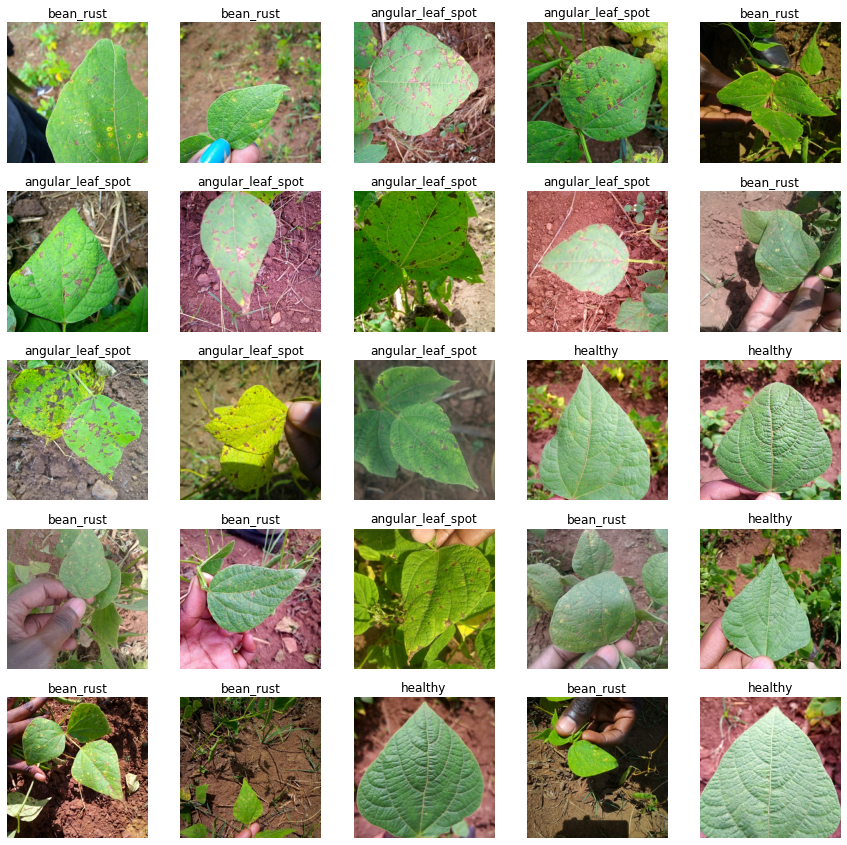

In [9]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(train.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  plt.title(class_names[datapoint["label"]])
  plt.axis("off")
plt.show()

In [10]:
NUM_EPOCHS = 10
BATCH_SIZE = 128
BUFFER_SIZE = 1000

IMAGE_SHAPE = [500, 500]
NUM_CLASSES = info.features["label"].num_classes

In [11]:
tf.random.uniform(())

<tf.Tensor: shape=(), dtype=float32, numpy=0.5145383>

In [12]:
@tf.function
def prepare_training_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.random_flip_left_right(input_image)
    input_image = tf.image.random_flip_up_down(input_image)
    input_image = tf.image.random_brightness(input_image, max_delta=0.3)
    input_image = tf.image.random_saturation(input_image, lower=0.75, upper=1.5)
    input_image = tf.image.random_contrast(input_image, lower=0.75, upper=1.5)

  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

def prepare_validation_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

In [13]:
train = train.map(prepare_training_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation = val.map(prepare_validation_data)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation.batch(BATCH_SIZE)

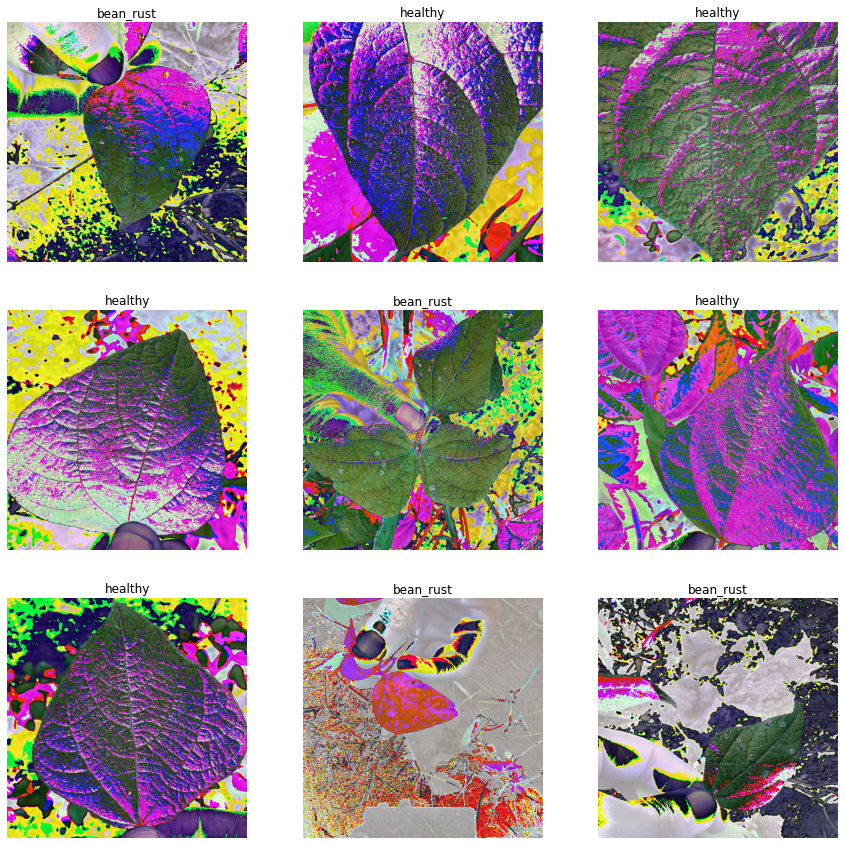

In [14]:
plt.figure(figsize=(15, 15))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  for datapoint in tfds.as_numpy(train_dataset.take(1)):
    plt.imshow(datapoint[0][0].astype('uint8'))
    plt.title(class_names[datapoint[1][0]])
    plt.axis("off")

plt.show()

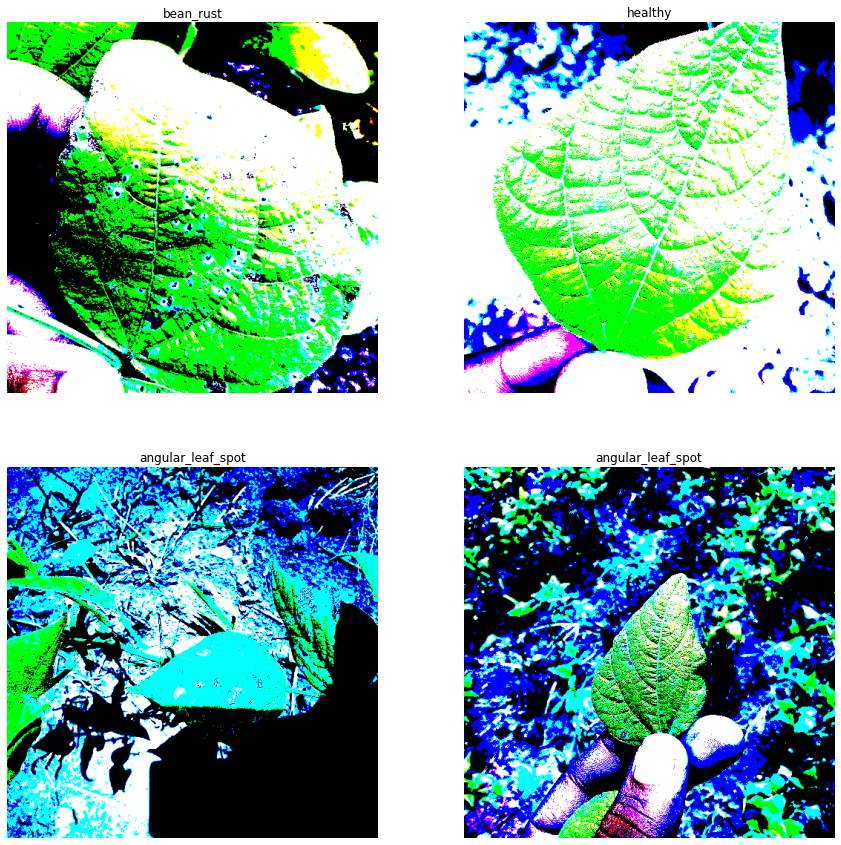

In [15]:
plt.figure(figsize=(15, 15))
for i in range(4):
  ax = plt.subplot(2, 2, i+1)
  for datapoint in tfds.as_numpy(train_dataset.take(1)):
    plt.imshow(datapoint[0][0])
    plt.title(class_names[datapoint[1][0]])
    plt.axis("off")

plt.show()

In [16]:
resnet = ResNet50(input_shape=IMAGE_SHAPE+[3], weights='imagenet', include_top=False)

for layer in resnet.layers:
  layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predicition = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=resnet.input, outputs=predicition)

94781440/94765736 [==============================] - 1s 0us/step


In [17]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [18]:
STEPS_PER_EPOCH = int(info.splits["train"].num_examples * 0.8)//BATCH_SIZE
VALIDATION_STEPS = int(info.splits["train"].num_examples * 0.1)//BATCH_SIZE

In [19]:
history = model.fit(
    train_dataset,
    epochs = NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/10
6/6 [==============================] - 36s 2s/step - loss: 1.7689 - accuracy: 0.4857
Epoch 2/10
6/6 [==============================] - 13s 2s/step - loss: 0.5961 - accuracy: 0.7585
Epoch 3/10
6/6 [==============================] - 11s 2s/step - loss: 0.4479 - accuracy: 0.8215
Epoch 4/10
6/6 [==============================] - 13s 2s/step - loss: 0.3620 - accuracy: 0.8620
Epoch 5/10
6/6 [==============================] - 11s 2s/step - loss: 0.2975 - accuracy: 0.8815
Epoch 6/10
6/6 [==============================] - 11s 2s/step - loss: 0.2424 - accuracy: 0.9231
Epoch 7/10
6/6 [==============================] - 14s 2s/step - loss: 0.2388 - accuracy: 0.9141
Epoch 8/10
6/6 [==============================] - 12s 2s/step - loss: 0.2474 - accuracy: 0.9077
Epoch 9/10
6/6 [==============================] - 12s 2s/step - loss: 0.1816 - accuracy: 0.9400
Epoch 10/10
6/6 [==============================] - 14s 2s/step - loss: 0.1768 - accuracy: 0.9427


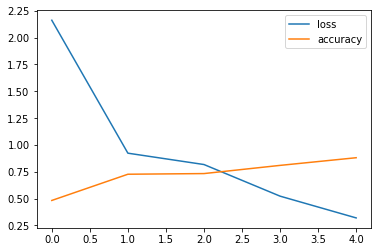

In [ ]:
import pandas as pd

pd.DataFrame(
    history.history
).plot()

## **Evaluating results**

In [ ]:
test_dataset = test.map(prepare_validation_data)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
model.evaluate(test_dataset)

1/1 [==============================] - 2s 2s/step - loss: 0.3459 - accuracy: 0.8516


[0.3458917438983917, 0.8515625]

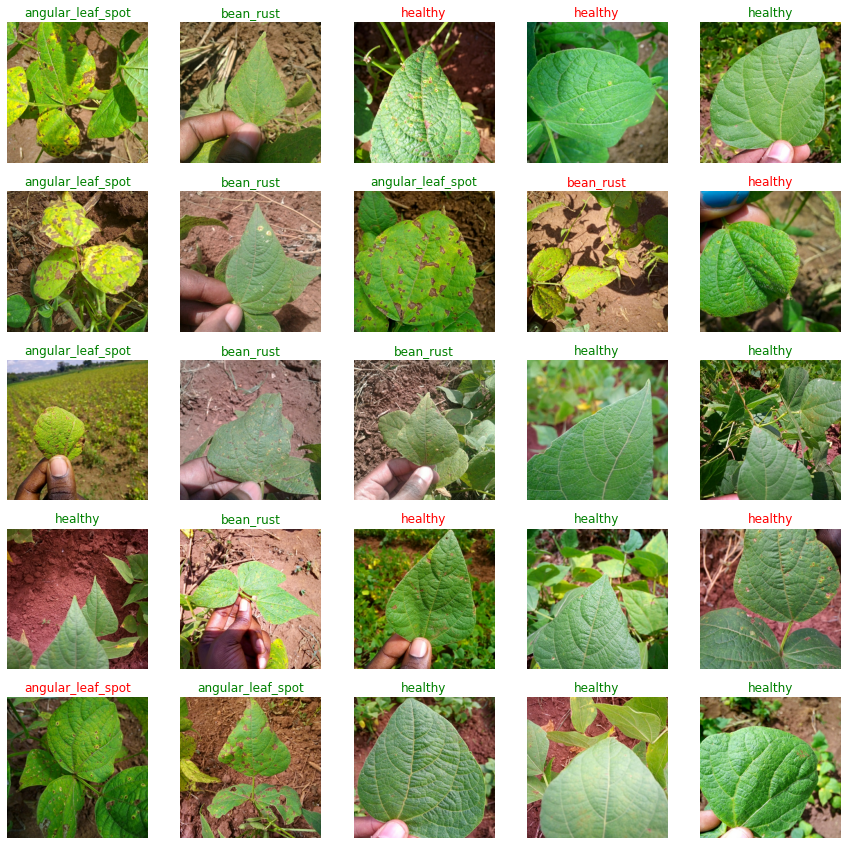

In [ ]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(test.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)

  if datapoint["label"] == np.argmax(model.predict(image)):
    plt.title(class_names[np.argmax(model.predict(image))], color="green")
  else:
    plt.title(class_names[np.argmax(model.predict(image))], color="red")

  plt.axis("off")

plt.show()